# U-W quiver plot from NEMO data

## Get some NEMO data from ZENODO

(See https://doi.org/10.5281/zenodo.3634491 / Thanks Swantje for providing them!)

In [1]:
!curl -O https://zenodo.org/record/3634491/files/NEMO_GYRE_test_data_all_files.v2020.02.03.1.zip
!unzip NEMO_GYRE_test_data_all_files.v2020.02.03.1.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19.7M  100 19.7M    0     0  5985k      0  0:00:03  0:00:03 --:--:-- 5987k
Archive:  NEMO_GYRE_test_data_all_files.v2020.02.03.1.zip
  inflating: GYRE_5d_00010101_00011230_grid_T.nc  
  inflating: GYRE_5d_00010101_00011230_grid_U.nc  
  inflating: GYRE_5d_00010101_00011230_grid_V.nc  
  inflating: GYRE_5d_00010101_00011230_grid_W.nc  
  inflating: mesh_mask.nc            


## Load data

In [2]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

In [3]:
dsU = (
    xr.open_dataset('GYRE_5d_00010101_00011230_grid_U.nc', decode_cf=False)
    .set_coords(["nav_lat", "nav_lon", "depthu"])
)
dsV = (
    xr.open_dataset('GYRE_5d_00010101_00011230_grid_V.nc', decode_cf=False)
    .set_coords(["nav_lat", "nav_lon", "depthv"])
)
dsW = (
    xr.open_dataset('GYRE_5d_00010101_00011230_grid_W.nc', decode_cf=False)
    .set_coords(["nav_lat", "nav_lon", "depthw"])
)

## Check scales

In [4]:
U_scale = ((dsU.vozocrtx ** 2).mean() ** 0.5).data[()]
V_scale = ((dsV.vomecrty ** 2).mean() ** 0.5).data[()]
W_scale = ((dsW.vovecrtz ** 2).mean() ** 0.5).data[()]

In [5]:
print("U", U_scale, "m/s")
print("V", V_scale, "m/s")
print("W", W_scale, "m/s")

U 0.017843701 m/s
V 0.019672427 m/s
W 2.3185603e-06 m/s


## Extract a section

In [6]:
U = dsU.vozocrtx.isel(y=16, time_counter=0)
W = dsW.vovecrtz.isel(y=16, time_counter=0)

## And plot

In [7]:
# for scaling W, we need the horizontal / vertical aspect ratio of the
# plot in meters
aspect_ratio = (
    (U.nav_lon.max() - U.nav_lon.min()) * 111e3 * np.cos(np.deg2rad(U.nav_lat.mean()))
    / (U.depthu.max() - U.depthu.min())
).data[()]
print(aspect_ratio)

419.7930243920544


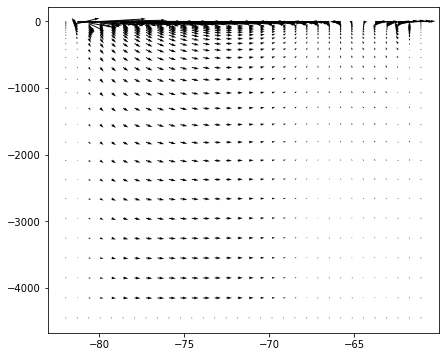

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.quiver(U.nav_lon, -U.depthu, U, W * aspect_ratio);

Doesn't look very nice near the surface. Let's interpolate?

## Let's interpolate

U with nearest neighbor interpolation, W with linear interpolation.

In [9]:
depth_levels = xr.DataArray(np.linspace(U.depthu.min(), U.depthu.max(), 31), dims=("z"))
depth_levels.coords["z"] = depth_levels
depth_levels

<xarray.DataArray (z: 31)>
array([   4.9752655 ,  153.18473256,  301.39419963,  449.60366669,
        597.81313375,  746.02260081,  894.23206787, 1042.44153493,
       1190.65100199, 1338.86046906, 1487.06993612, 1635.27940318,
       1783.48887024, 1931.6983373 , 2079.90780436, 2228.11727142,
       2376.32673848, 2524.53620555, 2672.74567261, 2820.95513967,
       2969.16460673, 3117.37407379, 3265.58354085, 3413.79300791,
       3562.00247498, 3710.21194204, 3858.4214091 , 4006.63087616,
       4154.84034322, 4303.04981028, 4451.25927734])
Coordinates:
  * z        (z) float64 4.975 153.2 301.4 ... 4.155e+03 4.303e+03 4.451e+03

In [10]:
U_interp = U.interp(depthu=depth_levels, method="nearest")
W_interp = W.interp(depthw=depth_levels, method="linear")

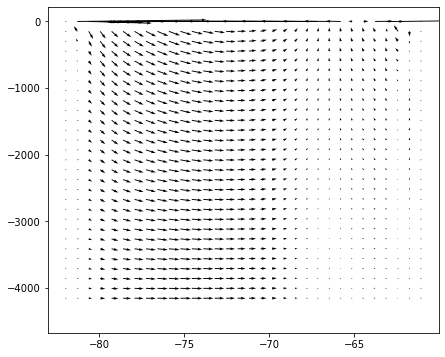

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.quiver(
    U_interp.nav_lon,
    -U_interp.z,
    U_interp,
    W_interp * aspect_ratio
);